# Covid-19 Prediction based on Chest X-Ray images 
## Introduction  
In this notebook, we are going to apply Transfer Learning using VGG16 on chest X-Ray images. Dataset is imbalanced (approx. 1:3), images may have different size and can have one or 3 color channels. We will preprocess our data in very simple and intuitive way (load, resize, create labels), then we will design and implement a deep learning model to detect covid-19 from chest X-Ray images.

## Load libraries 
We will use standard "data science" libraries including numpy, pandas, tensorflow, matplotlib and seaborn. Some additional libraries like os, glob and cv2 are used.

In [1]:
import os
import glob
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers
# Libraries for Transfer Learning
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [6]:
import seaborn
print(seaborn.__version__)

0.10.1


## Load Dataset
Our dataset consists of 3 folders - Train, Test, Val. Train & test are used for modeling, validation will be used to check performance of model. Size of validation set is very small (16 cases).  We will also create dataframes so we can visualize distribution of cases in each set.

In [3]:
path = '/content/drive/My Drive/Colab Notebooks/chest_xray/'

# define paths
train_dir = path + 'train/'
train_normal_dir = train_dir + 'NORMAL/'
train_covid_dir = train_dir + 'COVID-19/'

test_dir = path + 'test/'
test_normal_dir = test_dir + 'NORMAL/'
test_covid_dir = test_dir + 'COVID-19/'

val_dir = path + 'val/'
val_normal_dir = val_dir + 'NORMAL/'
val_covid_dir = val_dir + 'COVID-19/'

# find all files, our files has extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_covid_cases = glob.glob(train_covid_dir + '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_covid_cases = glob.glob(test_covid_dir + '*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_covid_cases = glob.glob(val_covid_dir + '*jpeg')

In [4]:
# listing the folders containing images

# Train Dataset
train_class_names=os.listdir(train_dir)
print("Train class names: %s" % (train_class_names))
# print("\n")

# Test Dataset
test_class_names=os.listdir(test_dir)
print("Test class names: %s" % (test_class_names))
# print("\n")

# Validation Dataset
val_class_names=os.listdir(val_dir)
print("Validation class names: %s" % (val_class_names))

print("\nDataset class name listing completed.")

Train class names: ['NORMAL', 'COVID-19']
Test class names: ['NORMAL', 'COVID-19']
Validation class names: ['NORMAL', 'COVID-19']

Dataset class name listing completed.


In [5]:
# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_covid_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_covid_cases:
    test_list.append([x, 1])
    
for x in val_normal_cases:
    val_list.append([x, 0])
    
for x in val_covid_cases:
    val_list.append([x, 1])


# shuffle/randomize data as they were loaded in order: normal cases, then covid cases
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)


# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])

In [6]:
train_df.head()

,image,label
0,/content/drive/My Drive/Colab Notebooks/chest_...,1
1,/content/drive/My Drive/Colab Notebooks/chest_...,1
2,/content/drive/My Drive/Colab Notebooks/chest_...,1
3,/content/drive/My Drive/Colab Notebooks/chest_...,0
4,/content/drive/My Drive/Colab Notebooks/chest_...,1


## Visualize distribution of cases 
Now let's draw how are our datasets (im)balanced. We will find out, that training dataset is highly imbalanced, testing dataset is slightly imbalanced and validation dataset is perfectly balanced.

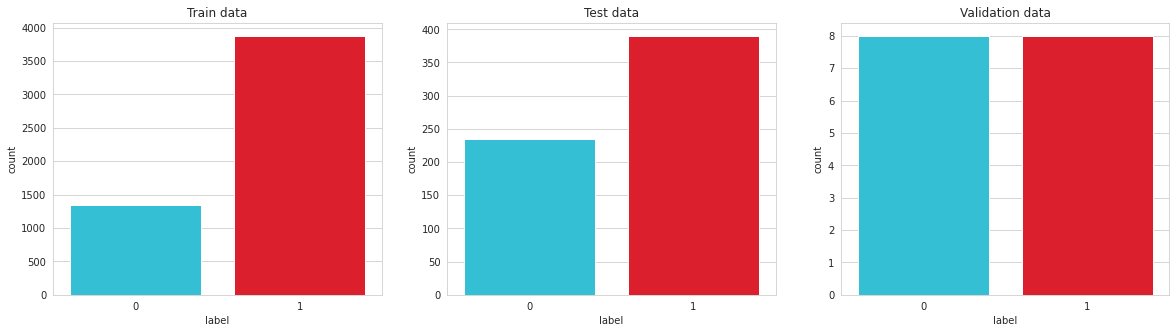

In [7]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.countplot(train_df['label'], palette=['#1ad3f0','#fa0011'])
plt.title('Train data')

plt.subplot(1,3,2)
sns.countplot(test_df['label'], palette=['#1ad3f0','#fa0011'])
plt.title('Test data')

plt.subplot(1,3,3)
sns.countplot(val_df['label'], palette=['#1ad3f0','#fa0011'])
plt.title('Validation data')

plt.show()

## Visualize some samples of each case
In this step we simply want to see few cases of covid-19 and few cases of healthy people. For uninterested person it may not be easy to identify covid-19 on image. You will also notice that images does not have same dimension and must be rescaled to same width & height.

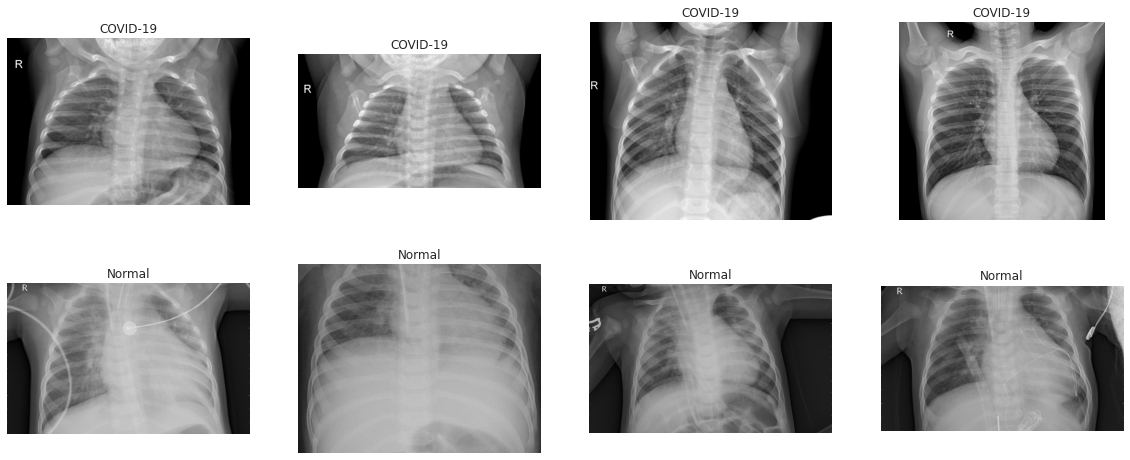

In [8]:
plt.figure(figsize=(20,8))
for i,img_path in enumerate(train_df[train_df['label'] == 0][0:4]['image']):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('COVID-19')
    
for i,img_path in enumerate(train_df[train_df['label'] == 1][0:4]['image']):
    plt.subplot(2,4,4+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Normal')

## Data preprocessing
In following section we are going to prepare our data for modeling. So, to make it simple we will define 2 functions :
- **preprocess_data :** load image, resize it, normalize and reshape to dimension required for tensorflow.
- **load_dataset :**  loop through images, generating 2 numpy arrays. First array contains image itself as a matrix, and the second array contains label.

In [9]:
def preprocess_data(img_path):
    img = cv2.imread(img_path,  cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (196, 196))
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = img/255.0
    img = np.reshape(img, (196,196,3))
    
    return img

def load_dataset(df):
    print("[INFO] Loading images ...")
    data = []
    labels = []

    for img_path, label in df.valuesb
        data.append(preprocess_data(img_path))
        labels.append(label)
        
    print("SUCCESSFULLY")    
    return np.array(data), np.array(labels)

Let's prepare our train, test and validation arrays from dataframes.

In [10]:
X_train, y_train = load_dataset(train_df)
X_test, y_test = load_dataset(test_df)
X_val, y_val = load_dataset(val_df)

print('Train data shape : {}, Labels shape : {}'.format(X_train.shape, y_train.shape))
print('Test data shape : {}, Labels shape : {}'.format(X_test.shape, y_test.shape))
print('Validation data shape : {}, Labels shape : {}'.format(X_val.shape, y_val.shape))

[INFO] Loading images ...
SUCCESSFULLY
[INFO] Loading images ...
SUCCESSFULLY
[INFO] Loading images ...
SUCCESSFULLY
Train data shape : (5216, 196, 196, 3), Labels shape : (5216,)
Test data shape : (624, 196, 196, 3), Labels shape : (624,)
Validation data shape : (16, 196, 196, 3), Labels shape : (16,)


It may be redudant step, but we are going to convert our 1D array of target labels into 2D array, changing classification from binary to categorical. 

In [11]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

## Data augmentation
Data augmentation is very important to make our model robust to unseen data. It takes each image and modify it slightly so simply said in each epoch, different image (generated from same) is sent to the model for training.

In [12]:
# define generator
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# fit generator on our train features
datagen.fit(X_train)

## Modelling with Transfer Learning 
First, we will check properties of the model that we are going to use for Transfer Learning

In [13]:
print("Summary of default VGG16 model.\n")

# initializing model with weights='imagenet'i.e. we are carring its original weights
model_vgg16=VGG16(weights='imagenet')

# display the summary to see the properties of the model
model_vgg16.summary()

Summary of default VGG16 model.

553467904/553467096 [==============================] - 22s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________

Here we will prepare the model as per our requirements.

In [14]:
img_width = 196
img_height = 196

print("Summary of Custom VGG16 model.\n")
print("1) We setup input layer and 2) We removed top (last) layer. \n")

# let us prepare our input_layer to pass our image size. default is (224,224,3). we will change it to (196,196,3)
input_layer=layers.Input(shape=(img_width,img_height,3))

# initialize the transfer model VGG16 with appropriate properties per our need.
# we are passing paramers as following
# 1) weights='imagenet' - Using this we are carring weights as of original weights.
# 2) input_tensor to pass the VGG16 using input_tensor
# 3) we want to change the last layer so we are not including top layer
model_vgg16=VGG16(weights='imagenet',input_tensor=input_layer,include_top=False)

# See the summary of the model with our properties.
model_vgg16.summary()

Summary of Custom VGG16 model.

1) We setup input layer and 2) We removed top (last) layer. 

58892288/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 196, 196, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 196, 196, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 196, 196, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 98, 98, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 98, 98, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None

Here we will access to the current last layer of the model and add flatten and dense after it.

In [15]:
print("Summary of Custom VGG16 model.\n")
print("1) We flatten the last layer and added 1 Dense layer and 1 output layer.\n")

last_layer=model_vgg16.output # we are taking last layer of the model

# Add flatten layer: we are extending Neural Network by adding flattn layer
flatten=layers.Flatten()(last_layer) 

# Add dense layer
# dense1=layers.Dense(100,activation='relu')(flatten)

# Add dense layer to the final output layer
output_layer=layers.Dense(2,activation='softmax')(flatten)

# Creating modle with input and output layer
model=models.Model(inputs=input_layer,outputs=output_layer)

# Summarize the model
model.summary()

Summary of Custom VGG16 model.

1) We flatten the last layer and added 1 Dense layer and 1 output layer.

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 196, 196, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 196, 196, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 196, 196, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 98, 98, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 98, 98, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 98, 98, 128)       147584    
______________

Now, we will freez all the layers except the last layer.

In [16]:
# we are making all the layers intrainable except the last layer
print("We are making all the layers intrainable except the last layer. \n")
for layer in model.layers[:-1]:
    layer.trainable=False
model.summary()

We are making all the layers intrainable except the last layer. 

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 196, 196, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 196, 196, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 196, 196, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 98, 98, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 98, 98, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 98, 98, 128)       147584    
______________________________________________________

## Training

In [17]:
optimizer = Adam(lr=0.0001, decay=1e-5)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) 

callback = EarlyStopping(monitor='loss', patience=8)

history = model.fit(datagen.flow(X_train,y_train, batch_size=4), 
                    validation_data=(X_test, y_test), 
                    epochs = 100, 
                    verbose = 1, 
                    callbacks=[callback],
                    class_weight={0:6.0, 1:0.5})

Epoch 1/100
1304/1304 [==============================] - 51s 39ms/step - loss: 0.2985 - accuracy: 0.8298 - val_loss: 0.2861 - val_accuracy: 0.8846
Epoch 2/100
1304/1304 [==============================] - 61s 47ms/step - loss: 0.1968 - accuracy: 0.9057 - val_loss: 0.2312 - val_accuracy: 0.9119
Epoch 3/100
1304/1304 [==============================] - 61s 47ms/step - loss: 0.1742 - accuracy: 0.9126 - val_loss: 0.2145 - val_accuracy: 0.9151
Epoch 4/100
1304/1304 [==============================] - 51s 39ms/step - loss: 0.1571 - accuracy: 0.9224 - val_loss: 0.2288 - val_accuracy: 0.9183
Epoch 5/100
1304/1304 [==============================] - 55s 42ms/step - loss: 0.1466 - accuracy: 0.9310 - val_loss: 0.2300 - val_accuracy: 0.9183
Epoch 6/100
1304/1304 [==============================] - 54s 42ms/step - loss: 0.1299 - accuracy: 0.9371 - val_loss: 0.2402 - val_accuracy: 0.9167
Epoch 7/100
1304/1304 [==============================] - 51s 39ms/step - loss: 0.1275 - accuracy: 0.9394 - val_loss: 0

## Evaluation 
First, we will quickly check the evolution of loss and accuracy over epochs and then draw confusion matrix and ROC curve on test data. Then how our validation set (16 cases) will work with our final model and compare real vs predicted label.

In [18]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss, Test Acc:", results)

Evaluate on test data
Test Loss, Test Acc: [0.22607265412807465, 0.9294871687889099]


### Loss & Accuracy training curves

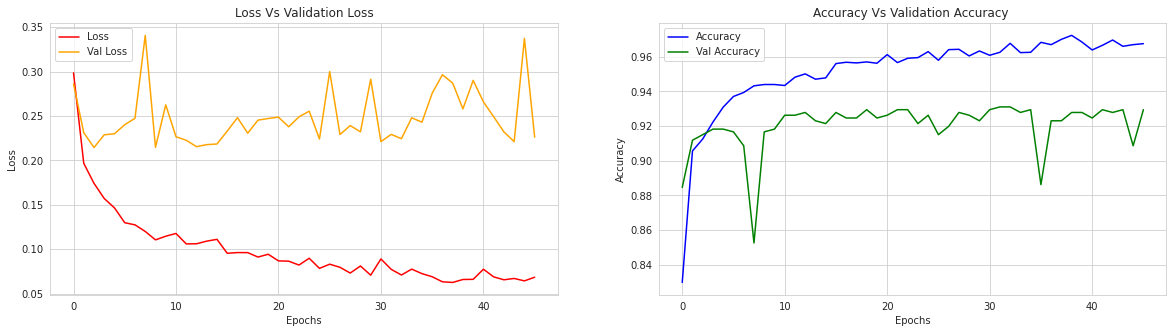

In [19]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='orange', label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Vs Validation Loss')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Vs Validation Accuracy ')
plt.legend(loc='best')

plt.show()

### Confusion matrix 

In [20]:
#Confusion Matrix on test data
y_test_hat = model.predict(X_test, batch_size=4)
y_test_hat = np.argmax(y_test_hat, axis=1)
y_test = np.argmax(y_test, axis=1)

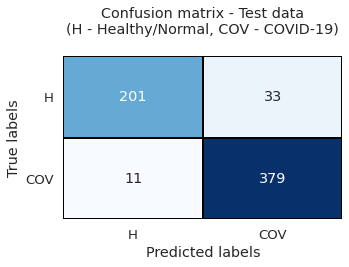


Classification report on Test data :

              precision    recall  f1-score   support

           0       0.95      0.86      0.90       234
           1       0.92      0.97      0.95       390

    accuracy                           0.93       624
   macro avg       0.93      0.92      0.92       624
weighted avg       0.93      0.93      0.93       624



In [23]:
# calculate confusion matrix & classification report
conf_m = confusion_matrix(y_test, y_test_hat)
clas_r = classification_report(y_test, y_test_hat)

# plot confusion matrix as heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True,xticklabels=['H', 'COV'], yticklabels=['H', 'COV'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix - Test data\n(H - Healthy/Normal, COV - COVID-19)\n')
plt.show()

# print classification report
print('\nClassification report on Test data :\n')
print(clas_r)

It seems that our model is more likely predicting covid, it is probably caused by imbalanced dataset and even setting class weights in tensorflow fit did not helped so much. We could increase weight for normal/healthy cases to get better results.

### ROC curve

In [25]:
pred_prob = model.predict(X_test)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# auc score
auc_score = roc_auc_score(y_test, pred_prob[:,1])

print('AUC Score : ',auc_score)

AUC Score :  0.9722331799254875


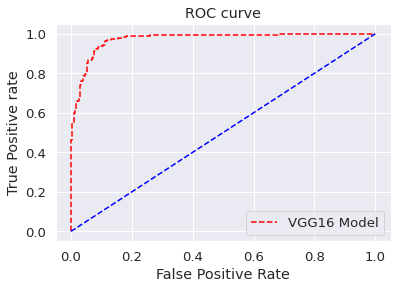

In [26]:
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='red', label='VGG16 Model')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

### Prediction on validation data 

In [27]:
#Validation Data
#First predict labels and get them to 1D array
y_val_hat = model.predict(X_val, batch_size=4)
y_val_hat = np.argmax(y_val_hat, axis=1)
y_val = np.argmax(y_val, axis=1)

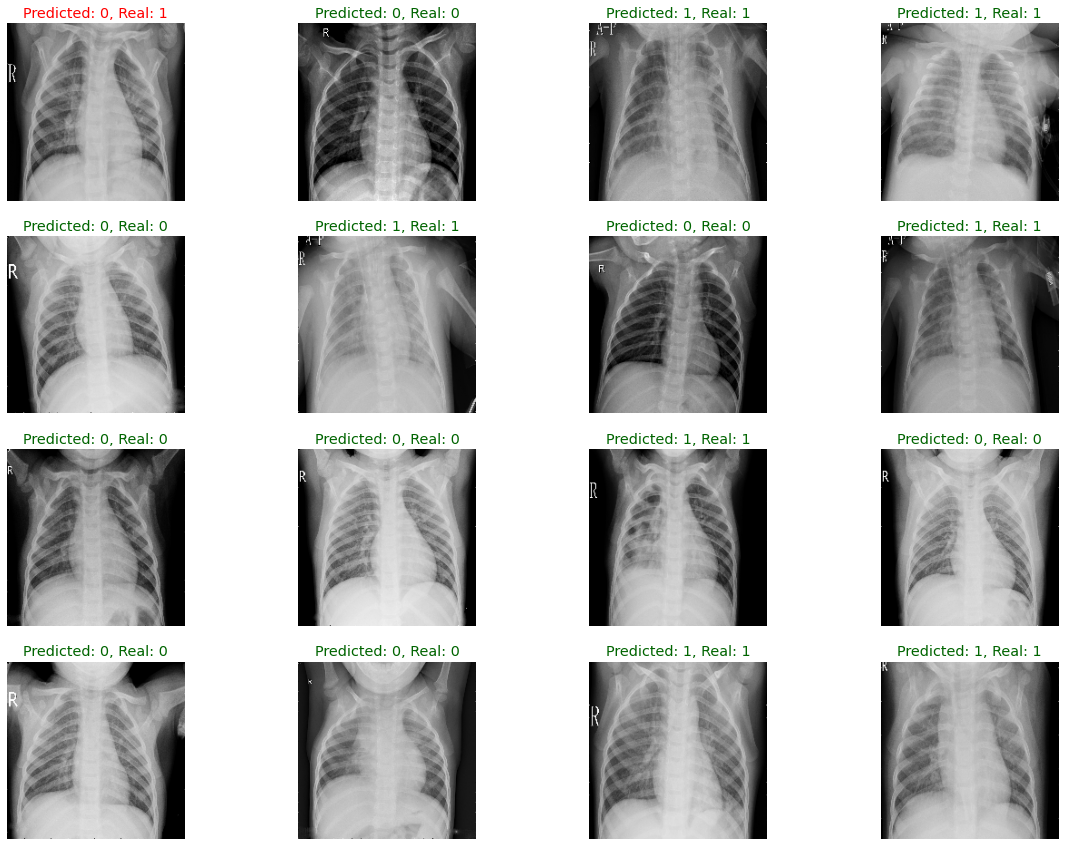

In [28]:
#Show images, real & predicted labels
plt.figure(figsize=(20,15))
for i,x in enumerate(X_val):
    plt.subplot(4,4,i+1)
    plt.imshow(x.reshape(196, 196,3), cmap='gray')
    plt.axis('off')  
   
    if y_val_hat[i] == y_val[i]: #setting up label color
        color='darkgreen' # if prediction is correct then green color
    else:
        color='red' # wrong then red colour
    
    plt.title('Predicted: {}, Real: {}'.format(y_val_hat[i], y_val[i]), color=color) 

There is just one misclassification ! Even doctors would have problems to classify it as correct, don't you think ? What about creating web app and allow doctors to upload their X-Rays and get information what is likelihood patient has covid-19 ?

## Save model

In [32]:
# serialize model to JSON
model_json = model.to_json()
with open("VGG16_model.json", "w") as json_file:
    json_file.write(model_json)
print("Saved JSON model to disk")
# serialize weights to HDF5
model.save_weights("VGG16_model.hdf5")
print("Saved HDF5 model to disk")
# serialize model to H5
model.save("VGG16_model.h5")
print("Saved H5 model to disk")

Saved JSON model to disk
Saved HDF5 model to disk
Saved H5 model to disk
